# DAV 6150 – Module 3 Assignment: Cleaning “Messy” Data  

## Group Members
- Arnold Muzarurwi
- Sharman Koropa
- Shelton Simbi
- Tafadzwa Kusikwenyu

## Goal  
Our goal is to explore and clean a dataset of about 12,800 wines in order to prepare it for machine learning. The response variable, `TARGET`, represents the number of cases of wine sold (an ordinal, count-like measure). The dataset includes a combination of chemical and physical properties (such as acidity, sulphates, alcohol, and pH) as well as expert and marketing-related fields (`STARS`, `LabelAppeal`).  

## Our Plan  
To achieve this, we will first load the data from a CSV file and begin with an exploratory data analysis (EDA). This will help us review the structure of the dataset, generate summary statistics, run data quality checks, and create visualizations to better understand both univariate and bivariate relationships.  

After that, we will move on to data preparation. In this stage, we will correct invalid values (for instance, negative numbers in chemical measures), impute missing values, address skewness and outliers, and apply transformations (such as log1p) when they can improve feature distributions.  

Once the data has been cleaned and adjusted, we will re-run our EDA to confirm that the quality of the dataset has improved and that it is ready for modeling. Finally, we will summarize our conclusions and export the cleaned dataset for use in future machine learning tasks.




In [5]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd

In [6]:
# Settings
pd.set_option("display.max_columns", None)
data_path = Path.home() / "Documents" / "Yeshiva " / "Data Science" / "M3_Data.csv"

In [7]:
wine_df = pd.read_csv("https://raw.githubusercontent.com/Shelton-beep/DAV-6150/refs/heads/main/M3_Data.csv")
raw = wine_df.copy()

In [8]:
# Basic shape & column list
shape = wine_df.shape
cols = wine_df.columns.tolist()
shape, cols

((12795, 16),
 ['INDEX',
  'TARGET',
  'FixedAcidity',
  'VolatileAcidity',
  'CitricAcid',
  'ResidualSugar',
  'Chlorides',
  'FreeSulfurDioxide',
  'TotalSulfurDioxide',
  'Density',
  'pH',
  'Sulphates',
  'Alcohol',
  'LabelAppeal',
  'AcidIndex',
  'STARS'])

# 2) Exploratory Data Analysis (EDA)

In [9]:
# ---- 2.1 Structure & Summary ----

desc = wine_df.describe(include="all").T
missing = wine_df.isna().sum().to_frame("missing_count")
dtypes = wine_df.dtypes.to_frame("dtype")

summary_table = desc.join([missing, dtypes])

# Show the first few rows
wine_df.head()


,INDEX,TARGET,FixedAcidity,VolatileAcidity,CitricAcid,ResidualSugar,Chlorides,FreeSulfurDioxide,TotalSulfurDioxide,Density,pH,Sulphates,Alcohol,LabelAppeal,AcidIndex,STARS
0,1,3,3.2,1.160,-0.98,54.2,-0.567,NaN,268.0,0.99280,3.33,-0.59,9.9,0,8,2.0
1,2,3,4.5,0.160,-0.81,26.1,-0.425,15.0,-327.0,1.02792,3.38,0.70,NaN,-1,7,3.0
2,4,5,7.1,2.640,-0.88,14.8,0.037,214.0,142.0,0.99518,3.12,0.48,22.0,-1,8,3.0
3,5,3,5.7,0.385,0.04,18.8,-0.425,22.0,115.0,0.99640,2.24,1.83,6.2,-1,6,1.0
4,6,4,8.0,0.330,-1.26,9.4,NaN,-167.0,108.0,0.99457,3.12,1.77,13.7,0,9,2.0


In [10]:
# display summaries
print(wine_df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12795 entries, 0 to 12794
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   INDEX               12795 non-null  int64  
 1   TARGET              12795 non-null  int64  
 2   FixedAcidity        12795 non-null  float64
 3   VolatileAcidity     12795 non-null  float64
 4   CitricAcid          12795 non-null  float64
 5   ResidualSugar       12179 non-null  float64
 6   Chlorides           12157 non-null  float64
 7   FreeSulfurDioxide   12148 non-null  float64
 8   TotalSulfurDioxide  12113 non-null  float64
 9   Density             12795 non-null  float64
 10  pH                  12400 non-null  float64
 11  Sulphates           11585 non-null  float64
 12  Alcohol             12142 non-null  float64
 13  LabelAppeal         12795 non-null  int64  
 14  AcidIndex           12795 non-null  int64  
 15  STARS               9436 non-null   float64
dtypes: f

In [11]:

print(wine_df.describe())

              INDEX        TARGET  FixedAcidity  VolatileAcidity  \
count  12795.000000  12795.000000  12795.000000     12795.000000   
mean    8069.980305      3.029074      7.075717         0.324104   
std     4656.905107      1.926368      6.317643         0.784014   
min        1.000000      0.000000    -18.100000        -2.790000   
25%     4037.500000      2.000000      5.200000         0.130000   
50%     8110.000000      3.000000      6.900000         0.280000   
75%    12106.500000      4.000000      9.500000         0.640000   
max    16129.000000      8.000000     34.400000         3.680000   

         CitricAcid  ResidualSugar     Chlorides  FreeSulfurDioxide  \
count  12795.000000   12179.000000  12157.000000       12148.000000   
mean       0.308413       5.418733      0.054822          30.845571   
std        0.862080      33.749379      0.318467         148.714558   
min       -3.240000    -127.800000     -1.171000        -555.000000   
25%        0.030000      -2.0000

In [12]:
# ---- 2.2 Data Integrity Checks ----
num_cols = wine_df.select_dtypes(include=[np.number]).columns.tolist()
# Columns where negative values make no physical sense (domain-based list)
non_negative_cols = [
    'FixedAcidity','VolatileAcidity','CitricAcid','ResidualSugar','Chlorides',
    'FreeSulfurDioxide','TotalSulfurDioxide','Density','pH','Sulphates','Alcohol','AcidIndex','STARS','TARGET'
]

neg_counts = {c: int((wine_df[c] < 0).sum()) for c in non_negative_cols if c in wine_df.columns}
zero_counts = {c: int((wine_df[c] == 0).sum()) for c in num_cols if c != "TARGET"}

skewness = wine_df[num_cols].skew(numeric_only=True)

integrity = pd.DataFrame({
    "negatives": pd.Series(neg_counts),
    "zeros": pd.Series(zero_counts),
    "skew": skewness
}).sort_index()

integrity

,negatives,zeros,skew
AcidIndex,0.0,0.0,1.648883
Alcohol,118.0,2.0,-0.030723
Chlorides,3197.0,5.0,0.030435
CitricAcid,2966.0,115.0,-0.050319
Density,0.0,0.0,-0.018698
FixedAcidity,1621.0,39.0,-0.022591
FreeSulfurDioxide,3036.0,11.0,0.006395
INDEX,NaN,0.0,-0.003250
LabelAppeal,NaN,5617.0,0.008431
ResidualSugar,3136.0,6.0,-0.053136


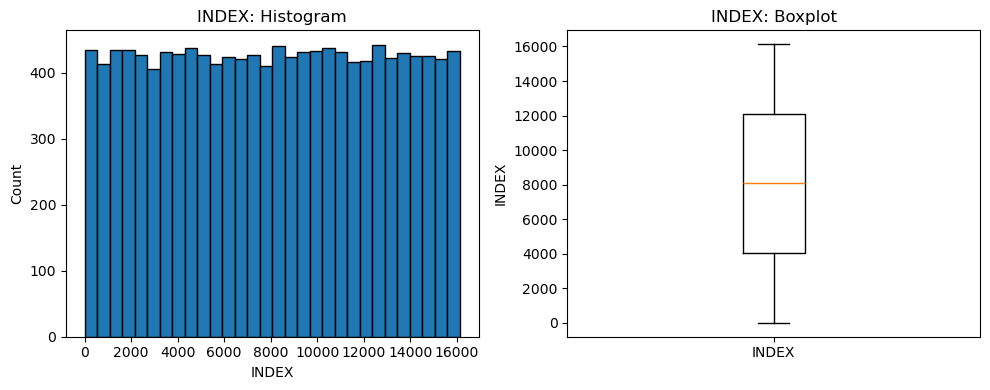

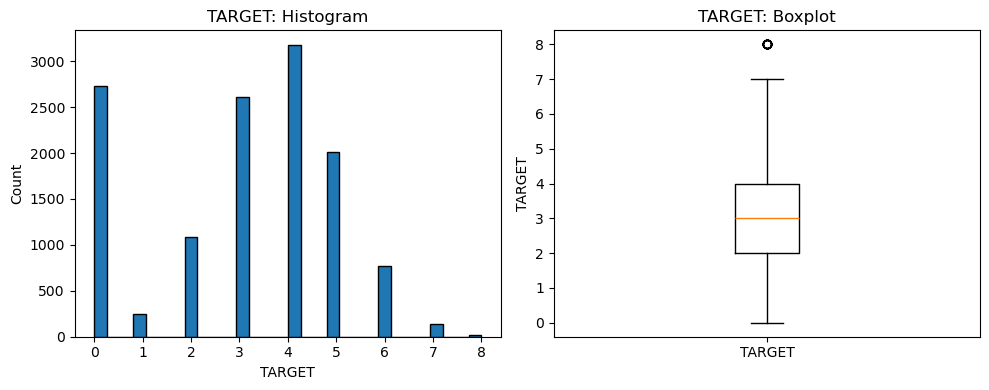

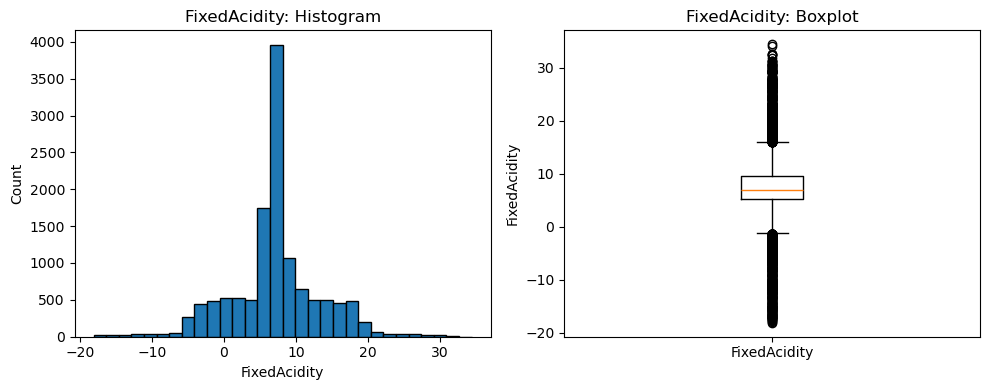

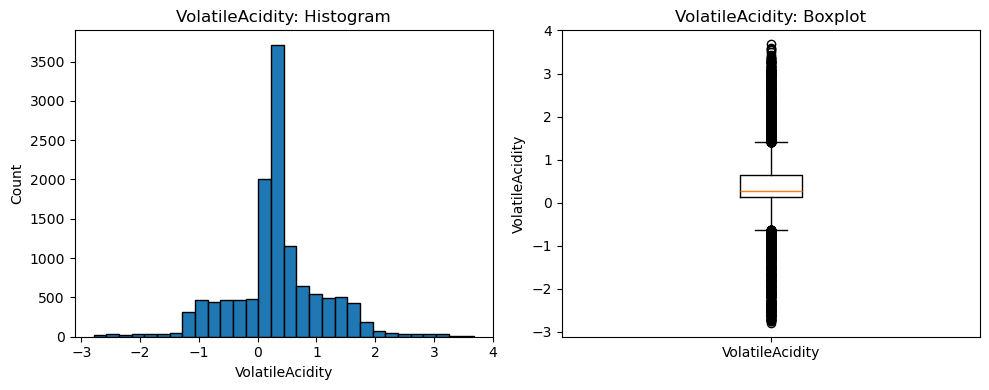

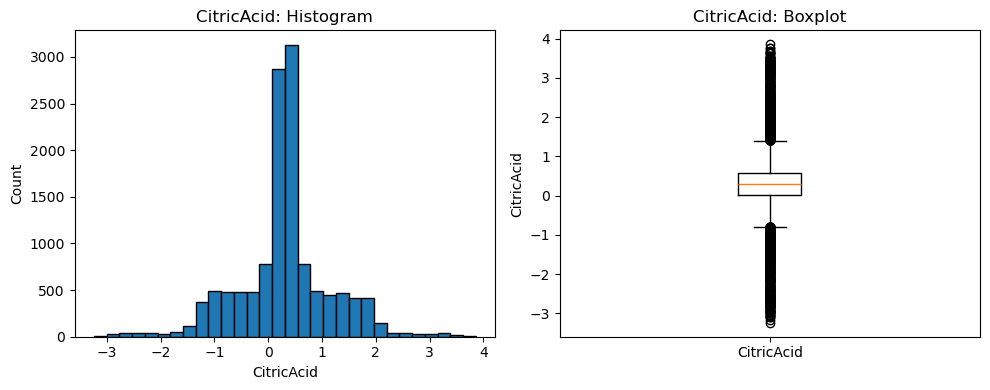

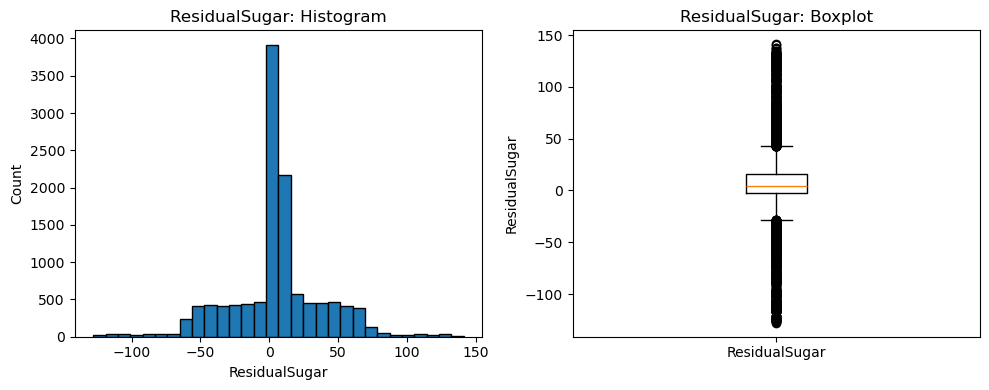

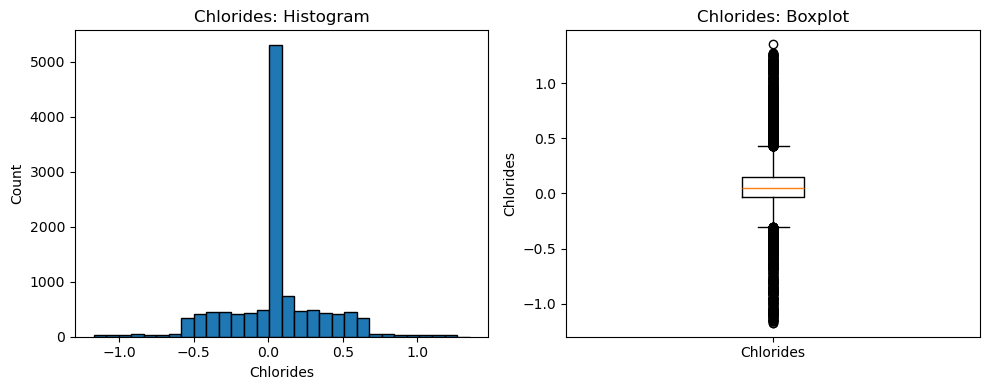

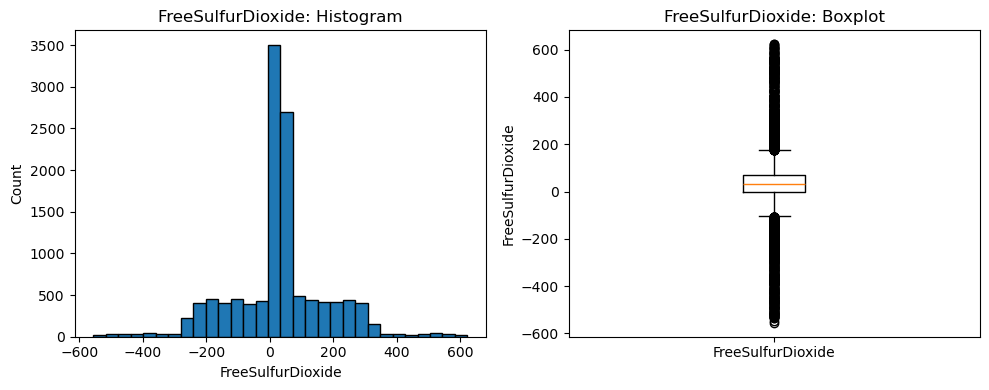

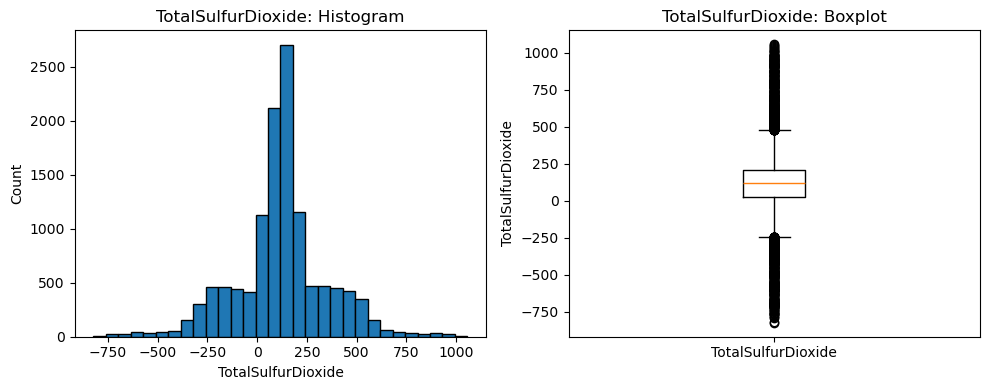

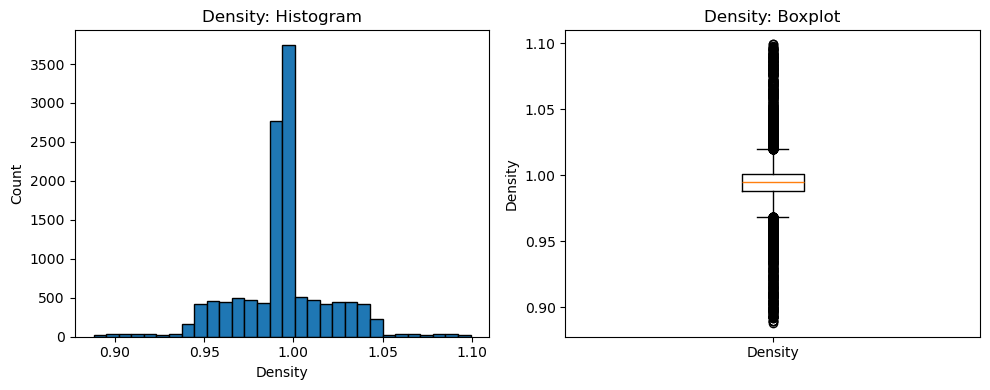

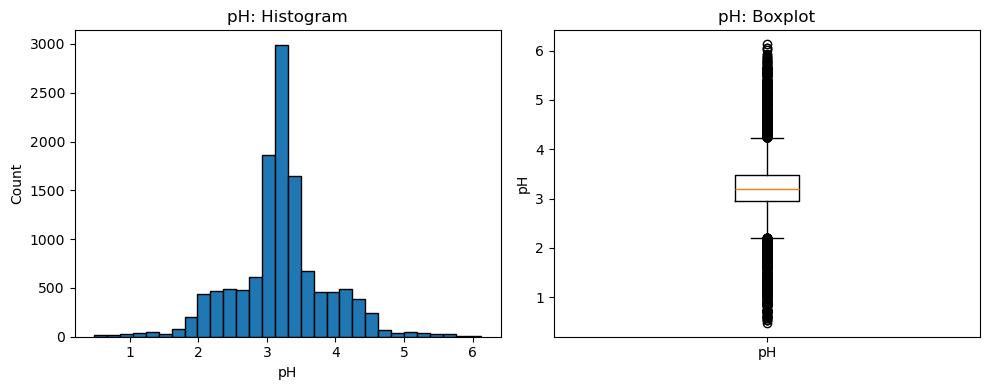

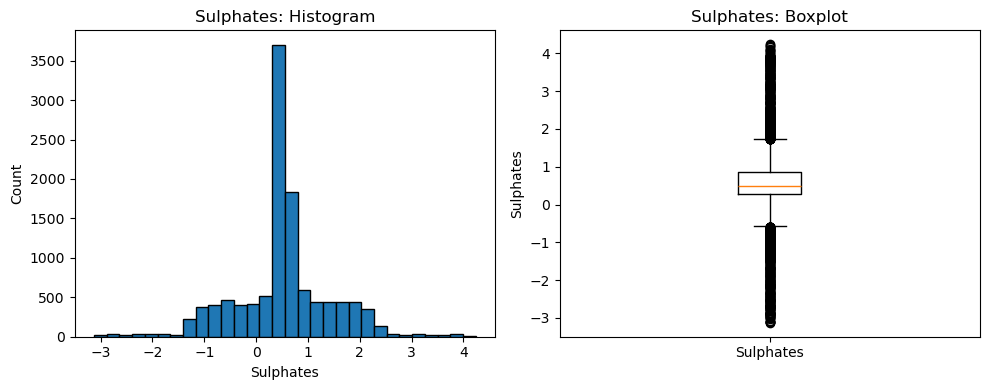

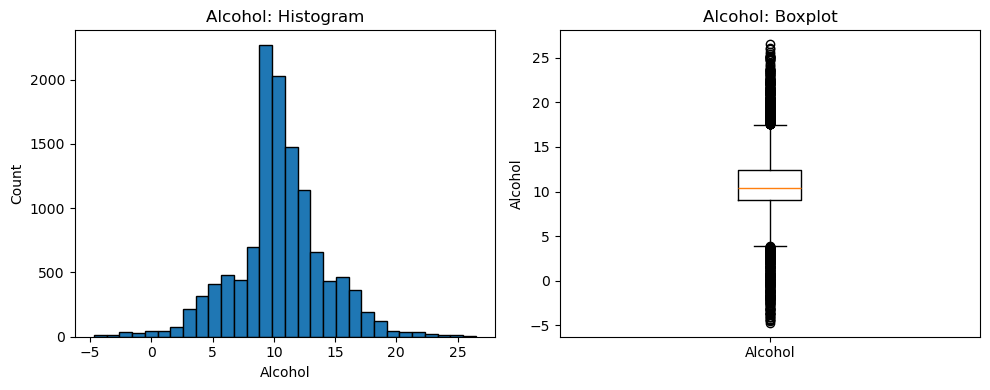

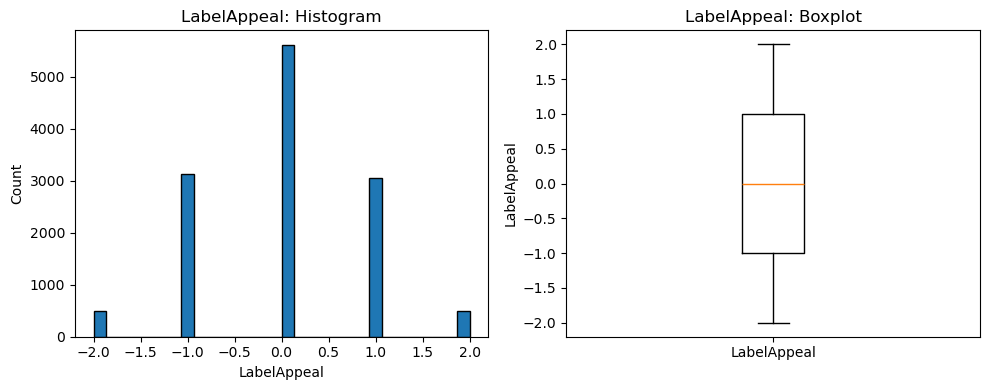

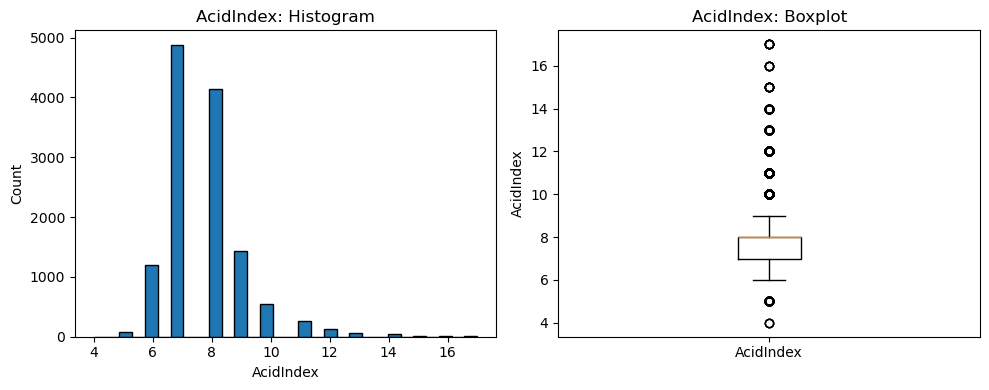

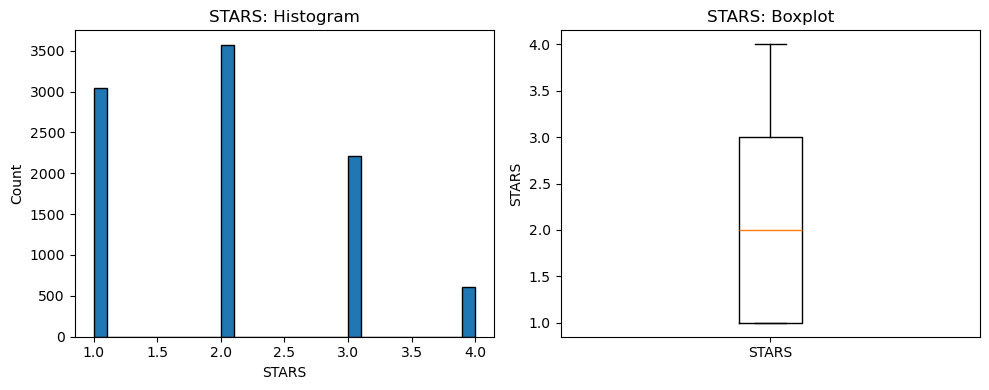

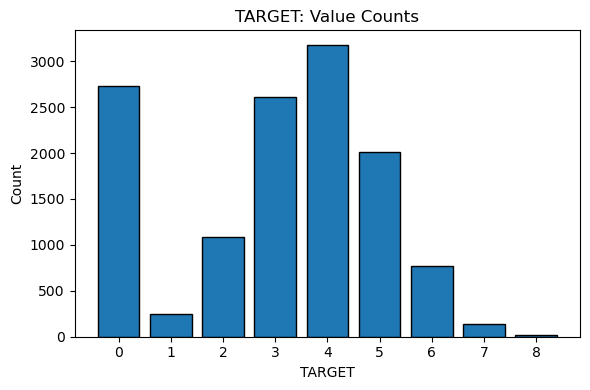

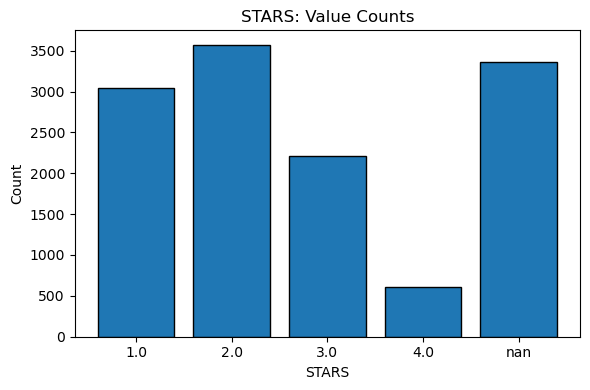

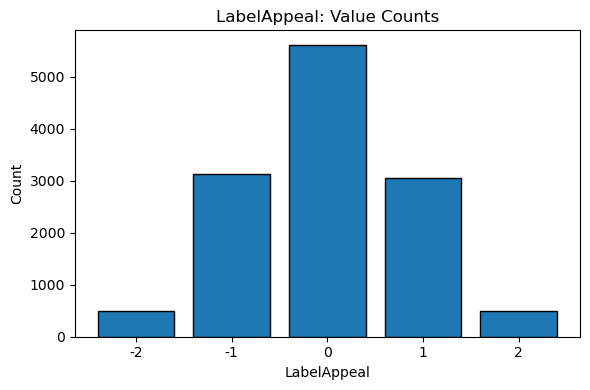

In [36]:
# ---- 2.3 Univariate Visuals (side-by-side plots; inline only) ----
import matplotlib.pyplot as plt

def hist_box_plot(series):
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    
    # Histogram
    axes[0].hist(series.dropna(), bins=30, edgecolor="black")
    axes[0].set_title(f"{series.name}: Histogram")
    axes[0].set_xlabel(series.name)
    axes[0].set_ylabel("Count")
    
    # Boxplot
    axes[1].boxplot(series.dropna(), vert=True, labels=[series.name])
    axes[1].set_title(f"{series.name}: Boxplot")
    axes[1].set_ylabel(series.name)
    
    plt.tight_layout()
    plt.show()

# Apply to all numeric columns
for c in num_cols:
    hist_box_plot(wine_df[c])

# For categorical/discrete columns (bar plots)
def bar_plot_counts(series):
    counts = series.value_counts(dropna=False).sort_index()
    plt.figure(figsize=(6,4))
    plt.bar(counts.index.astype(str), counts.values, edgecolor="black")
    plt.title(f"{series.name}: Value Counts")
    plt.xlabel(series.name)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

for c in ["TARGET","STARS","LabelAppeal"]:
    if c in wine_df.columns:
        bar_plot_counts(wine_df[c])


# Exploratory Data Analysis (EDA)

## INDEX
The index column behaves exactly as expected: a uniform spread across the dataset. The boxplot shows no meaningful outliers. Since it functions only as an identifier, it will not add value to the analysis and can likely be dropped.

---

## TARGET
The target variable ranges from 0 to 8. Most of the values fall between 2 and 5, with smaller groups at the extremes. The boxplot shows a concentration around the middle, with a few higher outliers. This will serve as the main outcome variable.

---

## Fixed Acidity
The values cluster mainly between 5 and 10, but there are plenty of extreme cases on both ends. The boxplot highlights outliers that could distort the distribution. This feature may need outlier treatment or transformation.

---

## Volatile Acidity
Most wines fall below 1, with a sharp peak around 0.2–0.3. Outliers extend well beyond 2, as shown in the boxplot. These outliers could represent unusual production batches and will need closer inspection.

---

## Residual Sugar
The histogram shows heavy skewness, with many values near zero but some extremely large (and even negative) readings. The boxplot confirms these extreme outliers. Negative values may indicate errors that need correction.

---

## Chlorides
The data are highly concentrated near zero, with a spike exactly at 0. The boxplot reveals extreme negatives and positives beyond ±1. These values are unusual and likely need validation.

---

## Free and Total Sulfur Dioxide
Both variables have skewed distributions with clusters between 0 and 200, but also contain negative values, which do not make sense chemically. The boxplots confirm many extreme outliers. Data cleaning will be necessary here.

---

## Density
Most values fall tightly around 0.99–1.0, which is expected for wine. A few outliers exist on either side, but overall this variable looks stable and valid.

---

## pH
The pH distribution is close to normal, centered near 3.2. The boxplot shows a few extreme lows and highs, but these remain within plausible biological ranges. Minimal cleaning is needed here.

---

## Sulphates
Most values are between 0 and 1, with outliers stretching into the negatives and above 3. Since sulphates should not be negative, those records likely represent errors.

---

## Alcohol
The alcohol content is fairly normally distributed, centered around 10 percent. Outliers exist at both the low and high ends, but most values stay within a realistic 8–12 percent range.

---

## LabelAppeal
This variable is symmetric around zero. The most common values are –1, 0, and +1, while extremes (–2 and +2) are rare. Most wines are perceived neutrally, with relatively few strongly liked or disliked labels.

---

## AcidIndex
The majority of values cluster around 7–8, with a few extending above 10. The boxplot shows these as outliers. Otherwise, the variable is fairly well-behaved.

---

## STARS
Star ratings mostly fall between 1 and 3, with 4 being the least frequent. The boxplot shows the distribution is fairly balanced, but tilted toward mid-level ratings.

---

# Value Counts

### TARGET
- 0 through 8 are all represented.  
- Mid-range values (3 and 4) dominate, with fewer cases at the extremes.

### STARS
- Ratings range from 1 to 4.  
- 2 stars is most common, followed by 1 and 3.  
- 4 stars is the least common.

### LabelAppeal
- Ranges from –2 to +2.  
- 0 is by far the most common, with –1 and +1 next.  
- Very few samples fall at –2 or +2.


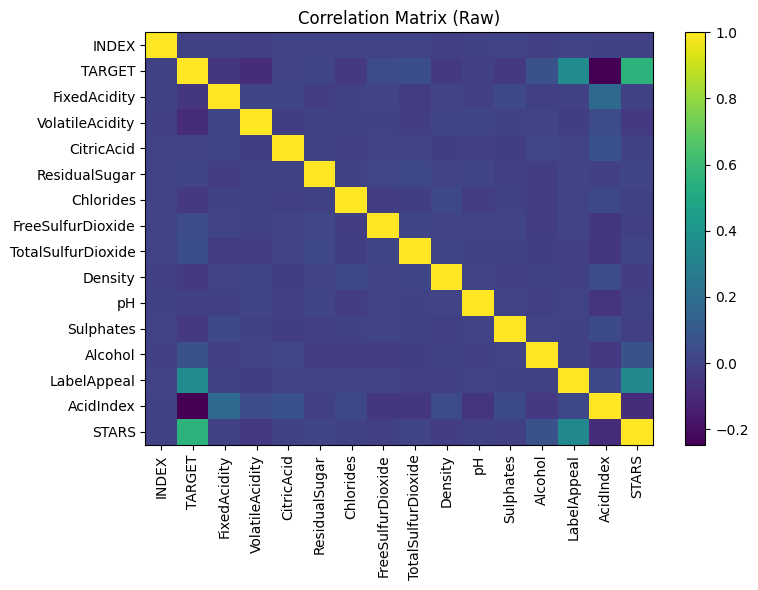

/var/folders/gz/fppvnc417qjdzcks58pv7xkw0000gn/T/ipykernel_79756/2641825976.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


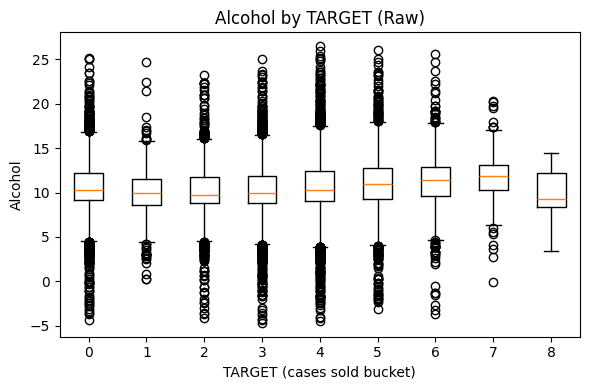

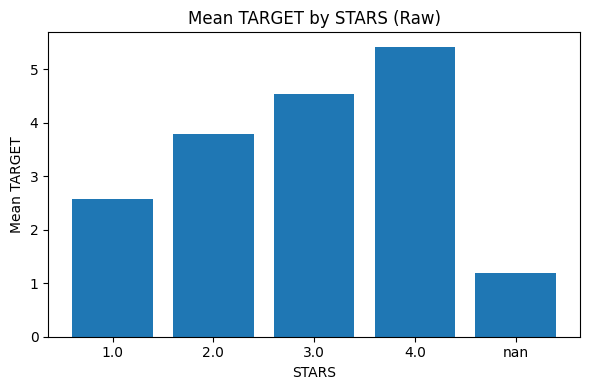

,INDEX,TARGET,FixedAcidity,VolatileAcidity,CitricAcid
INDEX,1.000000,0.001256,0.001133,-0.010224,0.004922
TARGET,0.001256,1.000000,-0.049011,-0.088793,0.008685
FixedAcidity,0.001133,-0.049011,1.000000,0.012375,0.014240
VolatileAcidity,-0.010224,-0.088793,0.012375,1.000000,-0.016953
CitricAcid,0.004922,0.008685,0.014240,-0.016953,1.000000


In [13]:
# ---- 2.4 Bivariate quick looks ----

# Correlation matrix (numeric only) using matplotlib imshow
corr = wine_df[num_cols].corr(numeric_only=True)
plt.figure(figsize=(8,6))
plt.imshow(corr, aspect='auto')
plt.title("Correlation Matrix (Raw)")
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.index)), corr.index)
plt.colorbar()
plt.tight_layout()
plt.show()

# Simple relationship: Alcohol vs TARGET (boxplot)
plt.figure(figsize=(6,4))
plt.boxplot(
    [wine_df.loc[wine_df["TARGET"]==t, "Alcohol"].dropna() 
     for t in sorted(wine_df["TARGET"].unique())],
    labels=sorted(wine_df["TARGET"].unique())
)
plt.title("Alcohol by TARGET (Raw)")
plt.xlabel("TARGET (cases sold bucket)")
plt.ylabel("Alcohol")
plt.tight_layout()
plt.show()

# Another relationship: STARS vs TARGET (bar of mean TARGET by STARS)
if "STARS" in wine_df.columns:
    grouped = wine_df.groupby("STARS", dropna=False)["TARGET"].mean()
    plt.figure(figsize=(6,4))
    plt.bar(grouped.index.astype(str), grouped.values)
    plt.title("Mean TARGET by STARS (Raw)")
    plt.xlabel("STARS")
    plt.ylabel("Mean TARGET")
    plt.tight_layout()
    plt.show()

# Just show a slice of the correlation matrix as a preview
corr.iloc[:5, :5]


# 3) Data Preparation
 We address integrity/usability issues identified in EDA:

 **Issues found (raw):**
 - Negative values in physical/chemical variables (invalid).
 - Missing values in several columns.
 - Heavy right-skew & outliers (e.g., ResidualSugar, Sulfur Dioxide measures).
 - Multicollinearity in related measures (FreeSulfurDioxide vs TotalSulfurDioxide).

 **Actions:**
 1. Convert clearly invalid negatives to NaN for physical chemistry columns.
 2. Impute numeric features with **median**, `STARS` with **mode** (rounded if needed).
 3. Cap extreme outliers using **IQR winsorization** (at lower/upper fences) to stabilize tails.
 4. Create **log1p-transformed** versions of the heaviest-skew features to aid linear models.
 5. Drop `INDEX` (identifier).

In [14]:
prep = wine_df.copy()

# 3.1 Set invalid negatives to NaN for non-negative physical columns
phys_cols = [
    'FixedAcidity','VolatileAcidity','CitricAcid','ResidualSugar','Chlorides',
    'FreeSulfurDioxide','TotalSulfurDioxide','Density','pH','Sulphates','Alcohol','AcidIndex','STARS'
]
for c in phys_cols:
    if c in prep.columns:
        prep.loc[prep[c] < 0, c] = np.nan

In [15]:
# 3.2 Impute missing values
for c in prep.columns:
    if c == "INDEX":
        continue
    if prep[c].dtype.kind in "biufc":
        if c == "STARS":
            mode_val = prep[c].mode(dropna=True)
            if len(mode_val) == 0:
                fill_val = np.nan
            else:
                fill_val = float(mode_val.iloc[0])
            prep[c] = prep[c].fillna(fill_val)
        else:
            prep[c] = prep[c].fillna(prep[c].median())

# 3.3 IQR winsorization for outliers on continuous variables
def winsorize_series(s: pd.Series, factor: float = 1.5) -> pd.Series:
    q1 = s.quantile(0.25)
    q3 = s.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - factor * iqr
    upper = q3 + factor * iqr
    return s.clip(lower, upper)

num_cols = wine_df.select_dtypes(include=[np.number]).columns.tolist()
cont_cols = [c for c in num_cols if c not in ("INDEX","TARGET")]

for c in cont_cols:
    prep[c] = winsorize_series(prep[c])

# 3.4 Create log1p transforms for heavy right-skew variables
skew_after_winsor = prep[cont_cols].skew()
heavy_skew_cols = [c for c in cont_cols if skew_after_winsor[c] > 1.0 and prep[c].min() >= 0]

for c in heavy_skew_cols:
    prep[c + "_log1p"] = np.log1p(prep[c])

# 3.5 Drop identifier
if "INDEX" in prep.columns:
    prep = prep.drop(columns=["INDEX"])

# Quick integrity check
prep_missing = prep.isna().sum()
prep_shape = prep.shape

prep_shape, prep_missing[prep_missing>0].sort_values(ascending=False)[:10]



((12795, 17), Series([], dtype: int64))

In [16]:
from pathlib import Path

# ---- 3.6 Persist cleaned data ----
out_dir = Path.home() / "Documents" / "DataScienceCourse"
out_dir.mkdir(parents=True, exist_ok=True)   # make sure the folder exists

clean_path = out_dir / "M3_Data_prepped.csv"
prep.to_csv(clean_path, index=False)

print("Saved to:", clean_path)
print("Shape:", prep.shape)


Saved to: /Users/tinashe/Documents/DataScienceCourse/M3_Data_prepped.csv
Shape: (12795, 17)


# 4) Prepped Data Review (Post-Prep EDA)
We compare before/after on distributions, skewness, and correlations for adjusted variables.


In [17]:
# ---- 4.1 Skewness before vs. after ----
pre_skew = raw.select_dtypes(include=[np.number]) \
              .drop(columns=["INDEX"], errors="ignore") \
              .skew(numeric_only=True)

post_skew = prep.select_dtypes(include=[np.number]) \
                .skew(numeric_only=True)

skew_compare = pd.concat(
    [pre_skew.rename("pre_skew"), post_skew.rename("post_skew")],
    axis=1
)

skew_compare["delta"] = skew_compare["post_skew"] - skew_compare["pre_skew"]
skew_compare_sorted = skew_compare.sort_values("pre_skew", ascending=False)

skew_compare_sorted


,pre_skew,post_skew,delta
AcidIndex,1.648883,0.231876,-1.417006
STARS,0.447378,0.000000,-0.447378
pH,0.044299,0.017535,-0.026764
Chlorides,0.030435,1.121016,1.090581
VolatileAcidity,0.020385,1.099557,1.079173
LabelAppeal,0.008431,0.008431,0.000000
FreeSulfurDioxide,0.006395,0.821036,0.814641
Sulphates,0.005913,0.736161,0.730248
TotalSulfurDioxide,-0.007181,0.547817,0.554998
Density,-0.018698,-0.028089,-0.009391


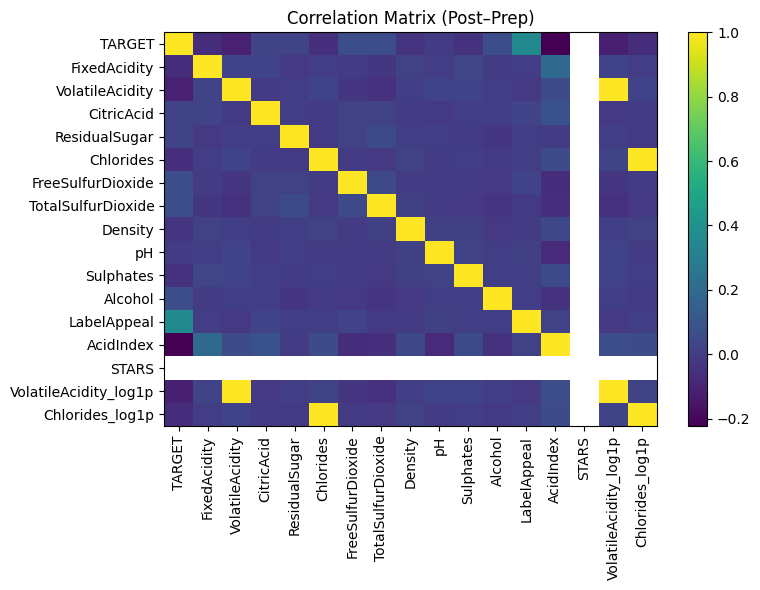

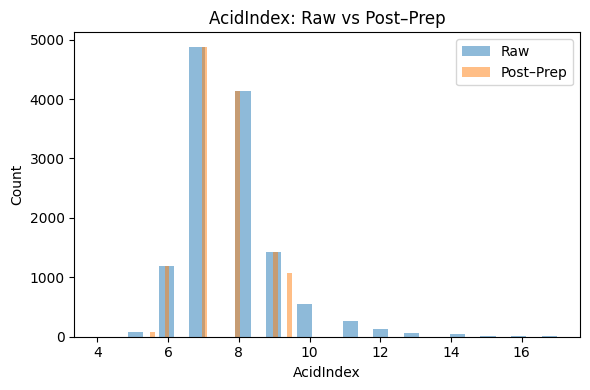

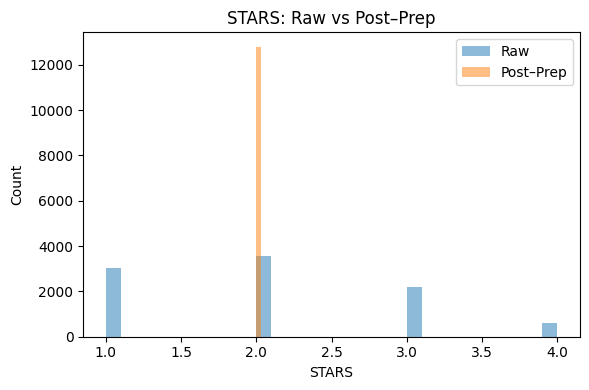

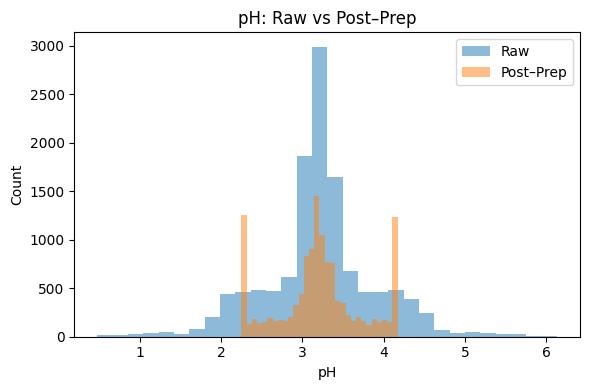

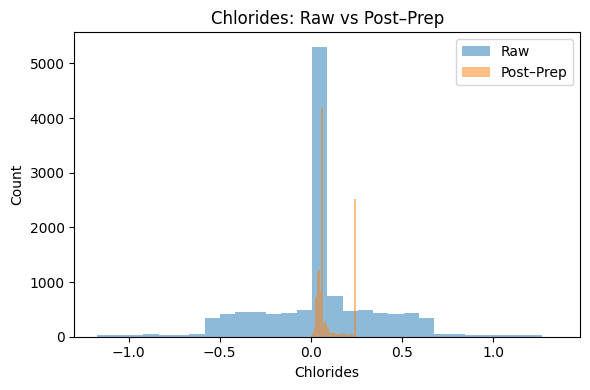

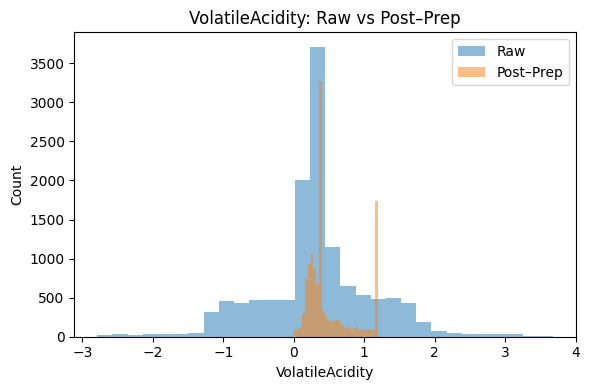

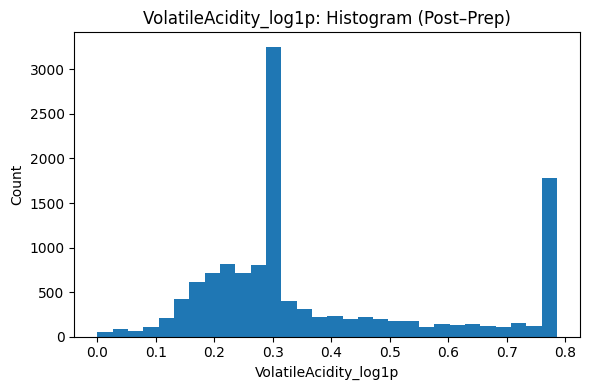

,TARGET,FixedAcidity,VolatileAcidity,CitricAcid,ResidualSugar,Chlorides,FreeSulfurDioxide,TotalSulfurDioxide,Density,pH,Sulphates,Alcohol,LabelAppeal,AcidIndex,STARS,VolatileAcidity_log1p,Chlorides_log1p
0,3,3.2,1.160,0.39,30.2,0.063,43.0,268.0,0.992800,3.33,0.575,9.90,0,8.0,2.0,0.770108,0.061095
1,3,4.5,0.160,0.39,26.1,0.063,15.0,150.0,1.019707,3.38,0.700,10.40,-1,7.0,2.0,0.148420,0.061095
2,5,7.1,1.195,0.39,14.8,0.037,113.5,142.0,0.995180,3.12,0.480,16.85,-1,8.0,2.0,0.786182,0.036332


In [18]:
# ---- 4.2 Correlation matrix after prep ----
post_num = prep.select_dtypes(include=[np.number])
corr_post = post_num.corr(numeric_only=True)

plt.figure(figsize=(8,6))
plt.imshow(corr_post, aspect='auto')
plt.title("Correlation Matrix (Post–Prep)")
plt.xticks(range(len(corr_post.columns)), corr_post.columns, rotation=90)
plt.yticks(range(len(corr_post.index)), corr_post.index)
plt.colorbar()
plt.tight_layout()
plt.show()

# ---- 4.3 Example: histograms before/after for top-skew features ----
def compare_hist(feature):
    plt.figure(figsize=(6,4))
    plt.hist(raw[feature].dropna(), bins=30, alpha=0.5, label="Raw")
    plt.hist(prep[feature].dropna(), bins=30, alpha=0.5, label="Post–Prep")
    plt.title(f"{feature}: Raw vs Post–Prep")
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.legend()
    plt.tight_layout()
    plt.show()

top_skew = skew_compare_sorted.index[:5].tolist()
for f in top_skew:
    if f in prep.columns and f in raw.columns and f != "TARGET":
        compare_hist(f)

# ---- 4.4 If log features were created, show one example ----
if heavy_skew_cols:
    f = heavy_skew_cols[0]
    plt.figure(figsize=(6,4))
    plt.hist(prep[f + "_log1p"].dropna(), bins=30)
    plt.title(f"{f}_log1p: Histogram (Post–Prep)")
    plt.xlabel(f + "_log1p")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

prep.head(3)


## 5) Conclusions

- **Validity fixes:** Replaced physically impossible negatives with NaN, then imputed; dropped the `INDEX` identifier.  
- **Missing data:** Imputed numerics with median and `STARS` with mode to preserve distribution center.  
- **Outliers:** IQR winsorization reduced extreme tails without discarding data.  
- **Skew:** Created log1p features for heavily right-skewed variables to help linear learners and stabilize variance.  
- **Readiness:** Dataset is now consistent (no invalid negatives, no missing values) and more suitable for ML.  

Overall, this workflow transformed a messy dataset into a clean and reliable resource for modeling.  
Through systematic exploratory analysis, outlier detection, skew correction, and handling of invalid or missing values, the dataset now reflects realistic wine characteristics and preserves its predictive features.  
This preparation ensures that future machine learning models trained on this dataset will be more robust, interpretable, and less biased by noise.  

 